In [1]:
modelIn = "microsoft-Multilingual-MiniLM-L12-H384-clickbait"
modelOut = "microsoft-Multilingual-MiniLM-L12-H384-clickbait2"

                                              # "cmarkea/distilcamembert-base-sentiment"
                                              # "cmarkea/distilcamembert-base" (accuracy=0,69)
                                              # "camembert-base"
                                              # "microsoft/Multilingual-MiniLM-L12-H384" (accuracy=0,64)
                                              # "nlptown/bert-base-multilingual-uncased-sentiment"
                                              # "distilbert-base-uncased-finetuned-sst-2-english"
                                              # "bert-base-uncased"
                                              # "bert-base-cased" <---
problem_type =  "regression"                  # Possible values: "regression", "single_label_classification", "multi_label_classification"
num_labels = 1                                # 5
dataCuratedPath = "Data/Curated"              # Columns separated by ";" to avoid numeric formats nightmare:
                                              #    'postText', 'targetTitle', 'targetDescription', 'id', 'truthMean
actualOutput = 'truthMean'
computedOutput = "labelC"
inputColumn = 'postText'
removeColumns = ['postText', 'targetTitle', 'targetDescription', 'id', 'truthMean'] # Il faut enlever les colonnes de type texte
splitFactor = 0.2                             # Proportion de données réservées pour les tests
push_to_hub = False
learning_rate = 5e-5
weight_decay=0.01

In [2]:
import torch
import numpy as np

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(modelIn)
model = AutoModelForSequenceClassification.from_pretrained(
   modelIn,
   problem_type=problem_type,
   num_labels = num_labels)

In [4]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elemen

In [5]:
for param in model.bert.embeddings.parameters():
    param.requires_grad = False

for param in model.bert.encoder.layer.parameters():
    param.requires_grad = False

In [6]:
print(tokenizer("Bonjour, comment ça va ?"))
print(tokenizer.tokenize("Hello, how are you?"))
print(tokenizer.encode("Bonjour, comment ça va ?"))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("Bonjour, comment ça va ?")))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode("Bonjour, comment ça va ?")))
print(tokenizer.decode(tokenizer.encode("Bonjour, comment ça va ?")))

{'input_ids': [0, 84602, 4, 6868, 3244, 307, 705, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
['▁Hello', ',', '▁how', '▁are', '▁you', '?']
[0, 84602, 4, 6868, 3244, 307, 705, 2]
[84602, 4, 6868, 3244, 307, 705]
['<s>', '▁Bonjour', ',', '▁comment', '▁ça', '▁va', '▁?', '</s>']
<s> Bonjour, comment ça va?</s>


In [7]:
import datasets as ds

In [8]:
curated = ds.load_from_disk(dataCuratedPath)

In [9]:
curated.to_pandas()

,postText,targetTitle,targetDescription,truthMean,id
0,"Panama Papers: Europol links 3,500 names to su...","Panama Papers: Europol links 3,500 names to su...",Law enforcement agency analysis uncovers proba...,0.066667,804113781580328960
1,The key to truly great chicken soup,A Superior Chicken Soup,For the best rendition of this American classi...,0.733333,804119512010424320
2,Afghan policewomen face down their fears to serve,100 Women 2016: On the frontline with the wome...,The Afghan women risking all to join the police.,0.333333,804121272967983104
3,Conservatives are watching less football this ...,Older Viewers and Conservatives Are Watching L...,"Many factors are dragging down NFL ratings, in...",0.066667,804123103995580416
4,Richard Sherman weighs in on Cam Newton’s stru...,Seattle Seahawks Richard Sherman Says 'Karma' ...,"Seattle Seahawks news, rumors, scores, schedul...",0.133333,804126501117435904
...,...,...,...,...,...
21907,Man who received world's first penis transplan...,World's first penis transplant patient is set ...,"Surgeons at Stellenbosch University, who carri...",0.600000,609056814819323905
21908,"RT @NYTSports: Abby didn't start, team couldn'...","At Women’s World Cup, Tie Leaves U.S. on Solid...",With Abby Wambach not starting for the first t...,0.266667,610125815116865536
21909,Obama defends Affordable Care Act ahead of Sup...,Obama Defends Health Law Ahead of Supreme Cour...,President Obama talks at the G7 summit in Germ...,0.400000,608338587495628801
21910,New study of the Deflategate report concludes ...,Deflating ‘Deflategate’,A new study weakens the case against the Patri...,0.400000,609684420082180096


In [10]:
longueur= len(curated)
longueur

21912

In [11]:
trie=sorted(curated[actualOutput])

In [12]:
import matplotlib.pyplot as plt

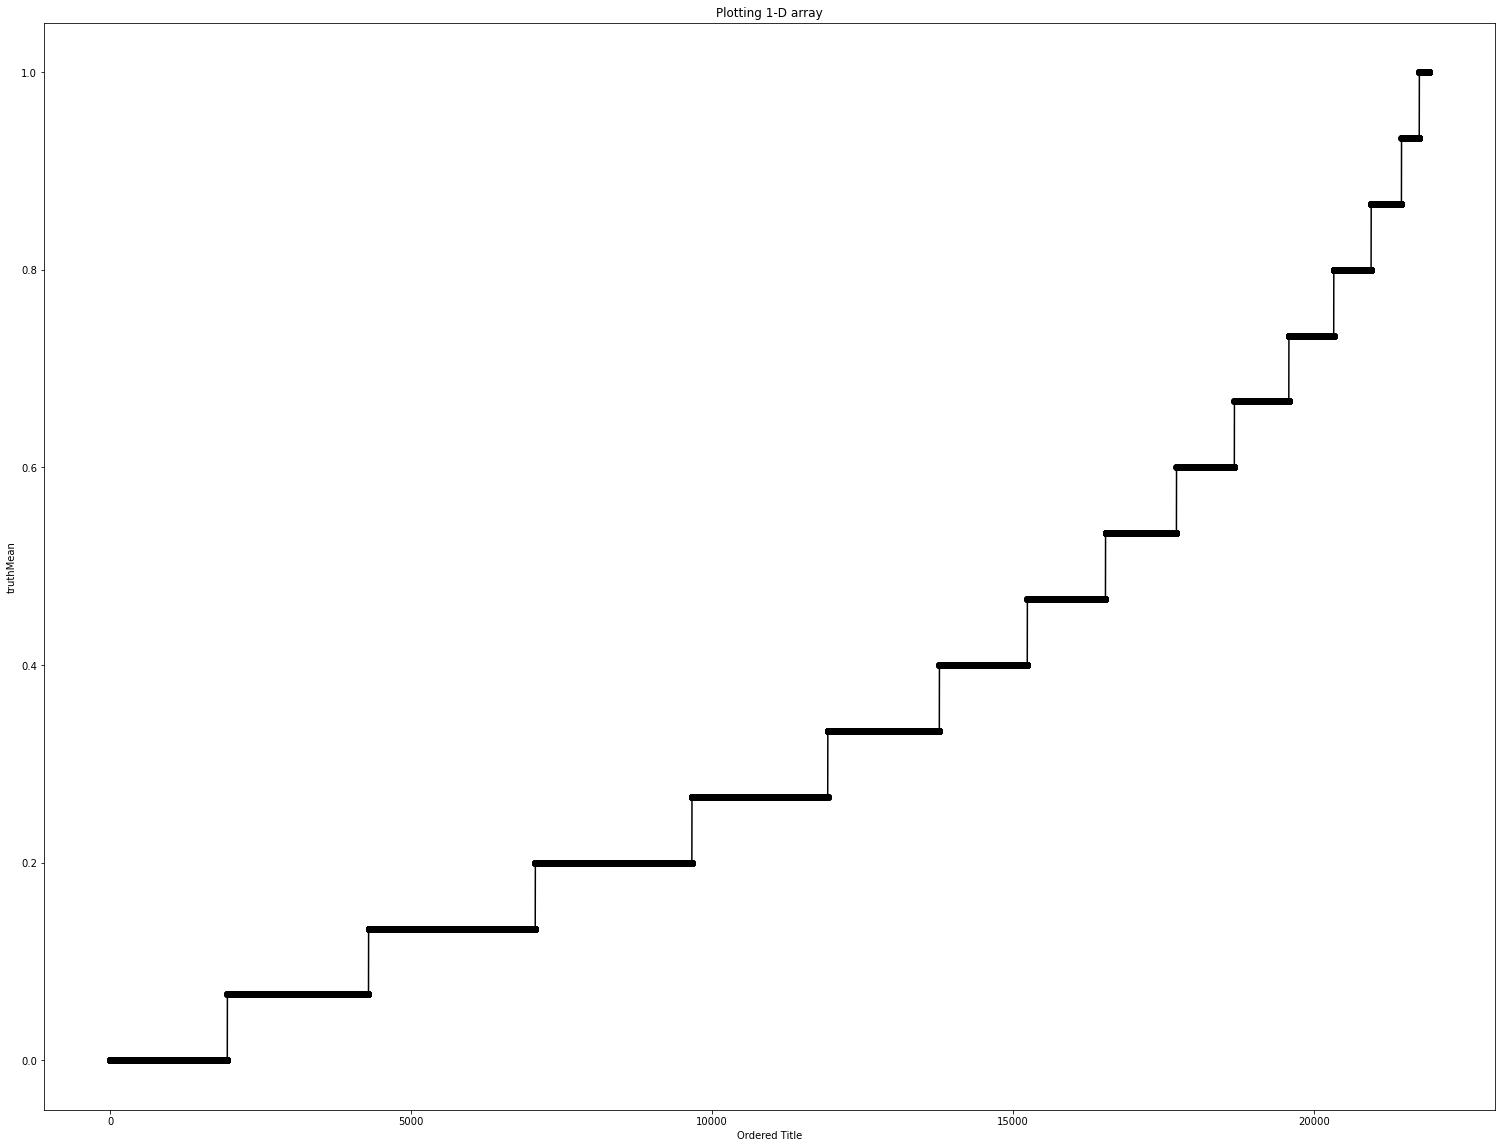

In [13]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(actualOutput)
x = np.array(range(0, longueur))
y = np.array(trie)
plt.plot(x, y, color = "black", marker = "o", label = "Array elements")

In [14]:
ncf=[None] * (num_labels-1)
for i in range(num_labels-1):
    ncf[i] = trie[longueur * (i+1) // num_labels]
ncf

[]

In [15]:
def tokenize(sample):
    tokenized_sample = tokenizer(
            sample[inputColumn],   #  postText + ". Paru dans " + sample["Page name"], #+ ", le " + sample["Publish time"]
            # str(int(sample[LCfraction]*100)), # on donne direct le résultat pour voir si accuracy == 1
            #padding=True,
            #truncation=True,
            #max_length=30
            )

    fraction = sample[actualOutput]
    
    if num_labels == 1:
        tokenized_sample["labels"] = fraction
    else:
        tokenized_sample["labels"] = next((x for x, val in enumerate(ncf) if fraction < val), num_labels-1)
    
    
    # print( fraction, tokenized_sample["input_ids"], tokenized_sample["labels"], sample[inputColumn])
    
    return tokenized_sample

In [16]:
tokenized_curated = curated.map(tokenize) #, batched=True)

  0%|          | 0/21912 [00:00<?, ?ex/s]

In [17]:
tokenized_curated

Dataset({
    features: ['postText', 'targetTitle', 'targetDescription', 'truthMean', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 21912
})

In [18]:
tokenized_curated.to_pandas().describe()

,truthMean,labels
count,21912.000000,21912.000000
mean,0.327942,0.327942
std,0.250260,0.250260
min,0.000000,0.000000
25%,0.133333,0.133333
50%,0.266667,0.266667
75%,0.466667,0.466667
max,1.000000,1.000000


In [19]:
print(tokenized_curated[0:3])

{'postText': ['Panama Papers: Europol links 3,500 names to suspected criminals', 'The key to truly great chicken soup', 'Afghan policewomen face down their fears to serve'], 'targetTitle': ['Panama Papers: Europol links 3,500 names to suspected criminals', 'A Superior Chicken Soup ', '100 Women 2016: On the frontline with the women policing the peace in Afghanistan'], 'targetDescription': ['Law enforcement agency analysis uncovers probable matches connected to terrorism, money laundering and organised crime', 'For the best rendition of this American classic, start with a whole bird.', 'The Afghan women risking all to join the police.'], 'truthMean': [0.06666666666, 0.73333333332, 0.33333333330000003], 'id': ['804113781580328960', '804119512010424320', '804121272967983104'], 'input_ids': [[0, 149674, 62323, 7, 12, 3939, 5877, 22317, 138, 4, 4283, 123055, 47, 92610, 297, 49602, 7, 2], [0, 581, 22799, 47, 87607, 6782, 143896, 101084, 2], [0, 57351, 1121, 35206, 3613, 1055, 2577, 7565, 236

In [20]:
tokenized_curated2 = tokenized_curated.train_test_split(splitFactor) # 0.2

In [21]:
tokenized_curated2['train'].to_pandas()

,postText,targetTitle,targetDescription,truthMean,id,input_ids,attention_mask,labels
0,Newborn baby dies after mum fell asleep holdin...,Warning to parents after newborn baby girl die...,A baby girl less than one month old has died a...,0.400000,853643905732096000,"[0, 2356, 57332, 15546, 14792, 7103, 42555, 77...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.400000
1,SpaceX Falcon 9 rocket boosts EchoStar communi...,SpaceX Falcon 9 rocket boosts EchoStar communi...,SpaceX Falcon 9 rocket boosts EchoStar communi...,0.000000,842322053713788929,"[0, 43045, 1542, 160378, 483, 13950, 126, 9755...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000
2,"Twins dominate ""Superhero Day,"" dress as RBG a...","Twins Dominate 'Superhero Day,' Dress As RBG A...",Their mom wants them to shatter glass ceilings...,0.066667,837212414328328192,"[0, 92016, 7, 35462, 67, 44, 73903, 90865, 100...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.066667
3,how moderate and reasonable,French Presidential Favourite Macron: Terroris...,"Macron describes terrorism as an ""imponderable...",0.666667,855411413430521856,"[0, 3642, 71644, 13, 136, 169022, 2]","[1, 1, 1, 1, 1, 1, 1]",0.666667
4,US Congress: Republicans vote to limit ethics ...,US Congress: Republicans vote to limit ethics ...,Republicans in the House of Representatives vo...,0.066667,816208996310908932,"[0, 7082, 77699, 12, 131161, 7, 43374, 47, 174...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.066667
...,...,...,...,...,...,...,...,...
17524,#ICYMI: Girl escaped car that entered Tweed Ri...,NSW floods: Girl escaped car that entered Twee...,Police divers will join the search this mornin...,0.066667,848991470484934656,"[0, 468, 16259, 1723, 10101, 12, 45327, 144281...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.066667
17525,Inside the fight to reinvent financial advice ...,The XX Factor: Inside The Fight To Reinvent Fi...,"Women live longer, earn less and are less like...",0.400000,857640501650096132,"[0, 187040, 70, 78431, 47, 456, 132894, 53477,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.400000
17526,Shetland Islands could go independent if Scotl...,Shetland Islands could go independent if Scotl...,The Shetland Islands could become an overseas ...,0.000000,851323109449891841,"[0, 4687, 74041, 18481, 7, 5809, 738, 41371, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.000000
17527,A Japanese man was found dead on top of his si...,A Japanese Man Was Crushed to Death by His Six...,A man simply known as Joji was found buried un...,0.200000,838502128960344064,"[0, 62, 148926, 332, 509, 14037, 103494, 98, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000


In [22]:
tokenized_curated3 = tokenized_curated2.remove_columns(removeColumns)

In [23]:
tokenized_curated4 = tokenized_curated3

In [24]:
tokenized_curated4

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 17529
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4383
    })
})

In [25]:
print(tokenized_curated4["train"][0:20])

{'input_ids': [[0, 2356, 57332, 15546, 14792, 7103, 42555, 77736, 10, 170572, 104064, 604, 2], [0, 43045, 1542, 160378, 483, 13950, 126, 97551, 7, 241, 3089, 44072, 36398, 7, 99675, 13, 3934, 103173, 98, 17932, 9790, 12, 2], [0, 92016, 7, 35462, 67, 44, 73903, 90865, 10013, 4, 58, 40989, 237, 627, 85556, 136, 78740, 10013, 180, 25, 11935, 13665, 2], [0, 3642, 71644, 13, 136, 169022, 2], [0, 7082, 77699, 12, 131161, 7, 43374, 47, 17475, 82, 75708, 7, 14361, 2], [0, 581, 88308, 47, 117, 37316, 6238, 5879, 32, 106516, 81423, 4, 241846, 939, 136, 76685, 6493, 163451, 90, 2], [0, 64614, 52851, 12535, 16030, 89406, 7, 44, 15123, 214, 959, 47, 4858, 217, 58, 7103, 10, 3445, 26038, 1257, 2363, 40, 257, 100, 10, 79063, 56, 2], [0, 11853, 621, 2773, 6897, 43515, 111, 24793, 450, 1221, 3249, 398, 1661, 1257, 136, 5646, 60322, 5, 2], [0, 72110, 28, 6991, 91736, 98, 79276, 7, 4, 2130, 761, 7, 4, 186, 99397, 2], [0, 44, 2729, 67, 17367, 58, 28987, 7, 25469, 13, 5879, 51042, 26548, 34202, 5879, 6, 21

In [26]:
from datasets import load_metric
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    if num_labels == 1:
        metric = load_metric("mse")
        return metric.compute(predictions=logits, references=labels)
    elif num_labels == 2:
        predictions = np.argmax(logits, axis=-1)
        accuracy = accuracy_score(y_true=labels, y_pred=predictions)
#    recall = recall_score(y_true=labels, y_pred=predictions)
#    precision = precision_score(y_true=labels, y_pred=predictions)
        f1 = f1_score(y_true=labels, y_pred=predictions)
    # return metric.compute(predictions=predictions, references=labels) # , average = 'weighted'
        return {"accuracy": accuracy, "f1": f1 } #" "matthews_correlation":matthews_correlation precision": precision, "recall": recall, "f1": f1, 
    else:
        predictions = np.argmax(logits, axis=-1)
        metric = load_metric("matthews_correlation") # matthews_correlation, accuracy "glue", "mrpc") # , "sst2") #  stsb de la ouatte de phoque
        matthews_correlation = metric.compute(predictions=predictions, references=labels)
        # accuracy = accuracy_score(y_true=labels, y_pred=predictions)
        # f1 = f1_score(y_true=labels, y_pred=predictions)
        return matthews_correlation
        # return {"accuracy": accuracy}.update(matthews_correlation)

In [27]:
from transformers import TrainingArguments

In [28]:
training_args = TrainingArguments(modelOut,
                                  evaluation_strategy= "steps", # "epoch",
                                  eval_steps = 50, # Evaluation and Save happens every 50 steps
                                  save_steps = 50,
                                  save_total_limit = 10, # Only last 5 models are saved. Older ones are deleted.
                                  num_train_epochs = 4,
                                  optim= 'adamw_torch',
                                  per_device_train_batch_size = 16,
                                  per_device_eval_batch_size = 16,
                                  learning_rate=learning_rate,
                                  weight_decay=weight_decay,
                                  # push_to_hub=push_to_hub,
                                  # metric_for_best_model = 'accuracy' if num_labels == 2 else 'mse' if num_labels == 1 else 'matthews_correlation',
                                  # greater_is_better = (num_labels != 1)
                                  load_best_model_at_end=True
                                 )

In [29]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

In [30]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_curated4["train"],
                  eval_dataset=tokenized_curated4["test"],
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  compute_metrics = compute_metrics,
                  callbacks = [EarlyStoppingCallback(early_stopping_patience=10)], #3
                  # optimizers=(torch.optim.AdamW, torch.optim.lr_scheduler.LambdaLR) 
                 )

In [31]:
# faire la boucle avec le trainer pytorch
# %pdb
if (modelIn != modelOut):
    trainer.train()

***** Running training *****
  Num examples = 17529
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4384


Step,Training Loss,Validation Loss,Mse
50,No log,0.019773,0.019773
100,No log,0.019951,0.019951
150,No log,0.020268,0.020268
200,No log,0.019678,0.019678
250,No log,0.020029,0.020029
300,No log,0.019948,0.019948
350,No log,0.020179,0.020179
400,No log,0.020042,0.020042
450,No log,0.019704,0.019704
500,0.021100,0.019707,0.019707


***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
Saving model checkpoint to microsoft-Multilingual-MiniLM-L12-H384-clickbait2\checkpoint-50
Configuration saved in microsoft-Multilingual-MiniLM-L12-H384-clickbait2\checkpoint-50\config.json
Model weights saved in microsoft-Multilingual-MiniLM-L12-H384-clickbait2\checkpoint-50\pytorch_model.bin
tokenizer config file saved in microsoft-Multilingual-MiniLM-L12-H384-clickbait2\checkpoint-50\tokenizer_config.json
Special tokens file saved in microsoft-Multilingual-MiniLM-L12-H384-clickbait2\checkpoint-50\special_tokens_map.json
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
Saving model checkpoint to microsoft-Multilingual-MiniLM-L12-H384-clickbait2\checkpoint-100
Configuration saved in microsoft-Multilingual-MiniLM-L12-H384-clickbait2\checkpoint-100\config.json
Model weights saved in microsoft-Multilingual-MiniLM-L12-H384-clickbait2\checkpoint-100\pytorch_model.bin
tokenizer config file saved in 

In [32]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16


{'eval_loss': 0.019677704200148582,
 'eval_mse': 0.019677703324344573,
 'eval_runtime': 5.9772,
 'eval_samples_per_second': 733.286,
 'eval_steps_per_second': 45.841,
 'epoch': 0.64}

In [33]:
# Sauver le modèle sur le disque
if (modelIn != modelOut):
    model.save_pretrained(modelOut)

Configuration saved in microsoft-Multilingual-MiniLM-L12-H384-clickbait2\config.json
Model weights saved in microsoft-Multilingual-MiniLM-L12-H384-clickbait2\pytorch_model.bin


In [34]:
if (modelIn != modelOut):
    tokenizer.save_vocabulary(modelOut)

In [59]:
# Pour voir si on fait de l'overfitting, rien de mieux que de dessiner le graphe avec le jeu d'entrainement
overfitting = "train" #  "train" # "test"

In [60]:
model.to(torch.device("cuda:0"))
predictions = trainer.predict(tokenized_curated2[overfitting])

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, truthMean, targetDescription, targetTitle, postText. If id, truthMean, targetDescription, targetTitle, postText are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 17529
  Batch size = 16


In [61]:
predictions.predictions

array([[0.34912944],
       [0.09140682],
       [0.13204798],
       ...,
       [0.18212228],
       [0.28967905],
       [0.3426766 ]], dtype=float32)

In [62]:
predictions.metrics

{'test_loss': 0.019677599892020226,
 'test_mse': 0.019677600672885775,
 'test_runtime': 26.0628,
 'test_samples_per_second': 672.568,
 'test_steps_per_second': 42.052}

In [63]:
tct = tokenized_curated2[overfitting].to_pandas()

In [64]:
tct

,postText,targetTitle,targetDescription,truthMean,id,input_ids,attention_mask,labels
0,Newborn baby dies after mum fell asleep holdin...,Warning to parents after newborn baby girl die...,A baby girl less than one month old has died a...,0.400000,853643905732096000,"[0, 2356, 57332, 15546, 14792, 7103, 42555, 77...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.400000
1,SpaceX Falcon 9 rocket boosts EchoStar communi...,SpaceX Falcon 9 rocket boosts EchoStar communi...,SpaceX Falcon 9 rocket boosts EchoStar communi...,0.000000,842322053713788929,"[0, 43045, 1542, 160378, 483, 13950, 126, 9755...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000
2,"Twins dominate ""Superhero Day,"" dress as RBG a...","Twins Dominate 'Superhero Day,' Dress As RBG A...",Their mom wants them to shatter glass ceilings...,0.066667,837212414328328192,"[0, 92016, 7, 35462, 67, 44, 73903, 90865, 100...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.066667
3,how moderate and reasonable,French Presidential Favourite Macron: Terroris...,"Macron describes terrorism as an ""imponderable...",0.666667,855411413430521856,"[0, 3642, 71644, 13, 136, 169022, 2]","[1, 1, 1, 1, 1, 1, 1]",0.666667
4,US Congress: Republicans vote to limit ethics ...,US Congress: Republicans vote to limit ethics ...,Republicans in the House of Representatives vo...,0.066667,816208996310908932,"[0, 7082, 77699, 12, 131161, 7, 43374, 47, 174...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.066667
...,...,...,...,...,...,...,...,...
17524,#ICYMI: Girl escaped car that entered Tweed Ri...,NSW floods: Girl escaped car that entered Twee...,Police divers will join the search this mornin...,0.066667,848991470484934656,"[0, 468, 16259, 1723, 10101, 12, 45327, 144281...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.066667
17525,Inside the fight to reinvent financial advice ...,The XX Factor: Inside The Fight To Reinvent Fi...,"Women live longer, earn less and are less like...",0.400000,857640501650096132,"[0, 187040, 70, 78431, 47, 456, 132894, 53477,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.400000
17526,Shetland Islands could go independent if Scotl...,Shetland Islands could go independent if Scotl...,The Shetland Islands could become an overseas ...,0.000000,851323109449891841,"[0, 4687, 74041, 18481, 7, 5809, 738, 41371, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.000000
17527,A Japanese man was found dead on top of his si...,A Japanese Man Was Crushed to Death by His Six...,A man simply known as Joji was found buried un...,0.200000,838502128960344064,"[0, 62, 148926, 332, 509, 14037, 103494, 98, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000


In [65]:
if num_labels == 1:
    tct[computedOutput] = predictions.predictions
else:
    tct[computedOutput] = np.argmax(predictions.predictions, axis=1)   

In [66]:
tct1 = tct.sort_values(actualOutput)
tct2 = tct.sort_values(computedOutput)

In [67]:
palette = ["r", "g", "b", "c", "m"]

In [68]:
if num_labels == 1:
    color1 = [val for val in tct1[computedOutput]]
    color2 = [val for val in tct1[actualOutput]]
else:
    color1 = [palette[val] for val in tct1[computedOutput]]
    color2 = [palette[val] for val in tct1[actualOutput]]

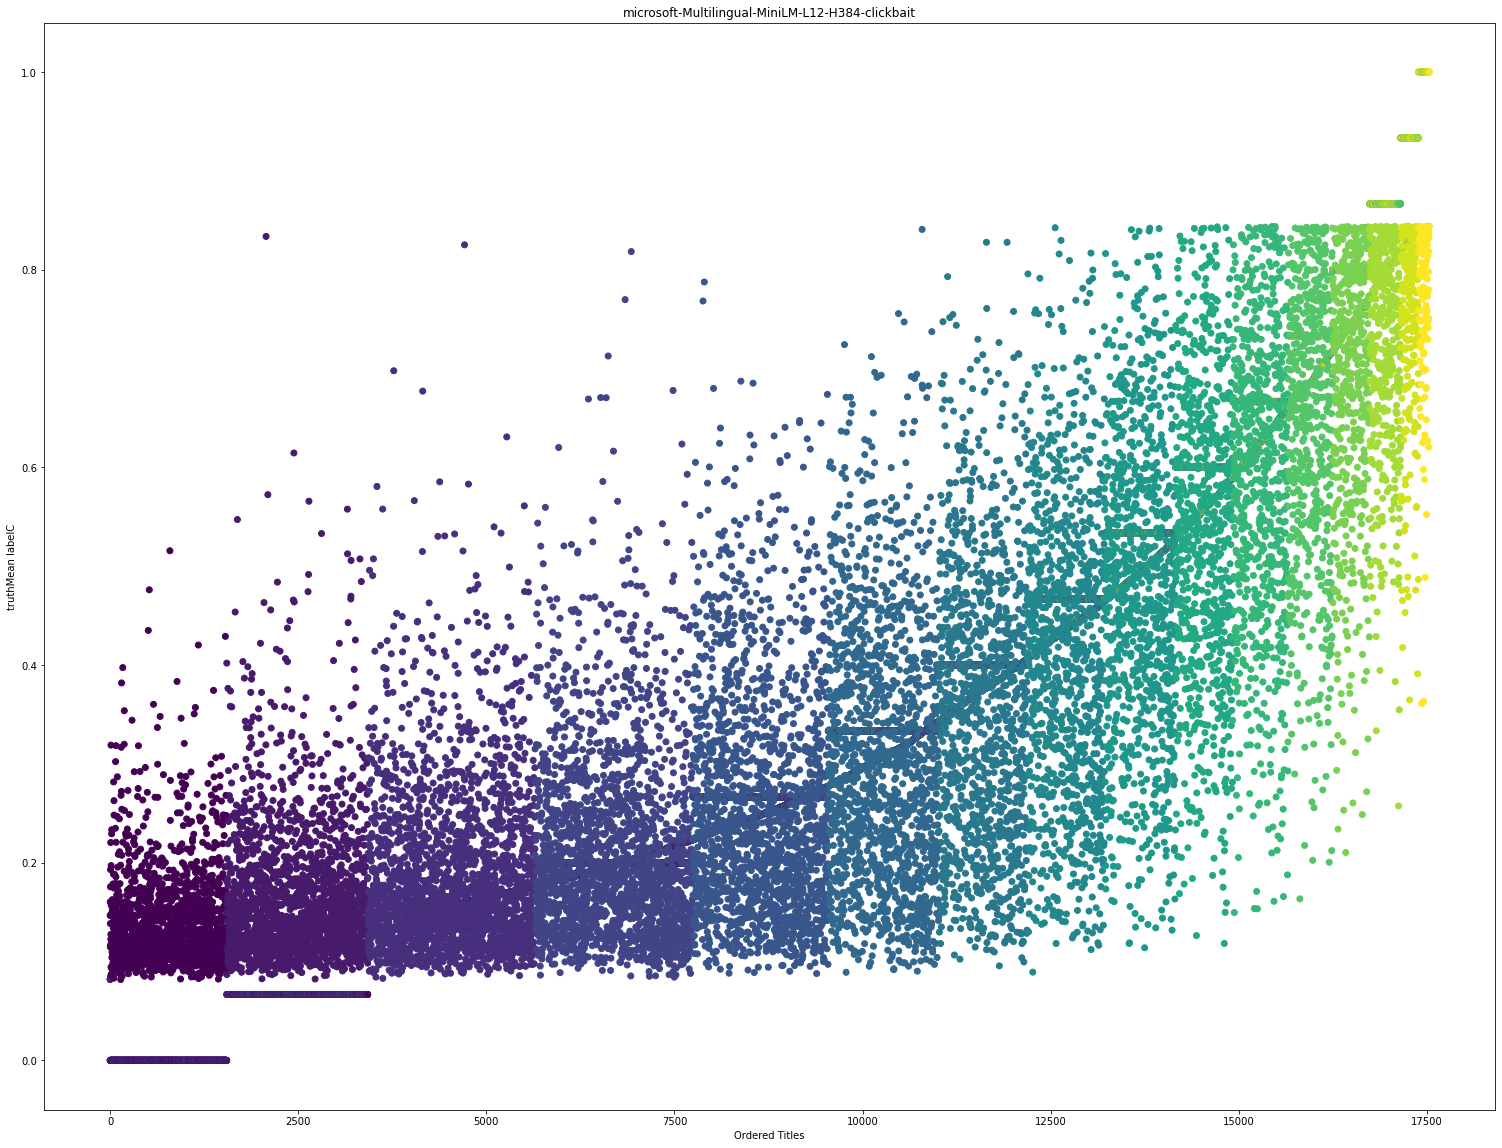

In [69]:
plt.figure(figsize=(26, 20))
plt.title(modelIn)
plt.xlabel("Ordered Titles")

plt.ylabel(actualOutput + " " + computedOutput)

x = np.array(range(0, tct1.shape[0]))
y = tct1[actualOutput]
plt.scatter(x, y, c = color1, marker = "o", label = "Array elements")

x2 = np.array(range(0, tct2.shape[0]))
y2 = tct2[computedOutput]
plt.scatter(x2, y2, c = color1, marker = "o", label = "Array elements")

x3 = np.array(range(0, tct1.shape[0]))
y3 = tct1[computedOutput]
plt.scatter(x3, y3, c = color2, marker = "o", label = "Array elements")


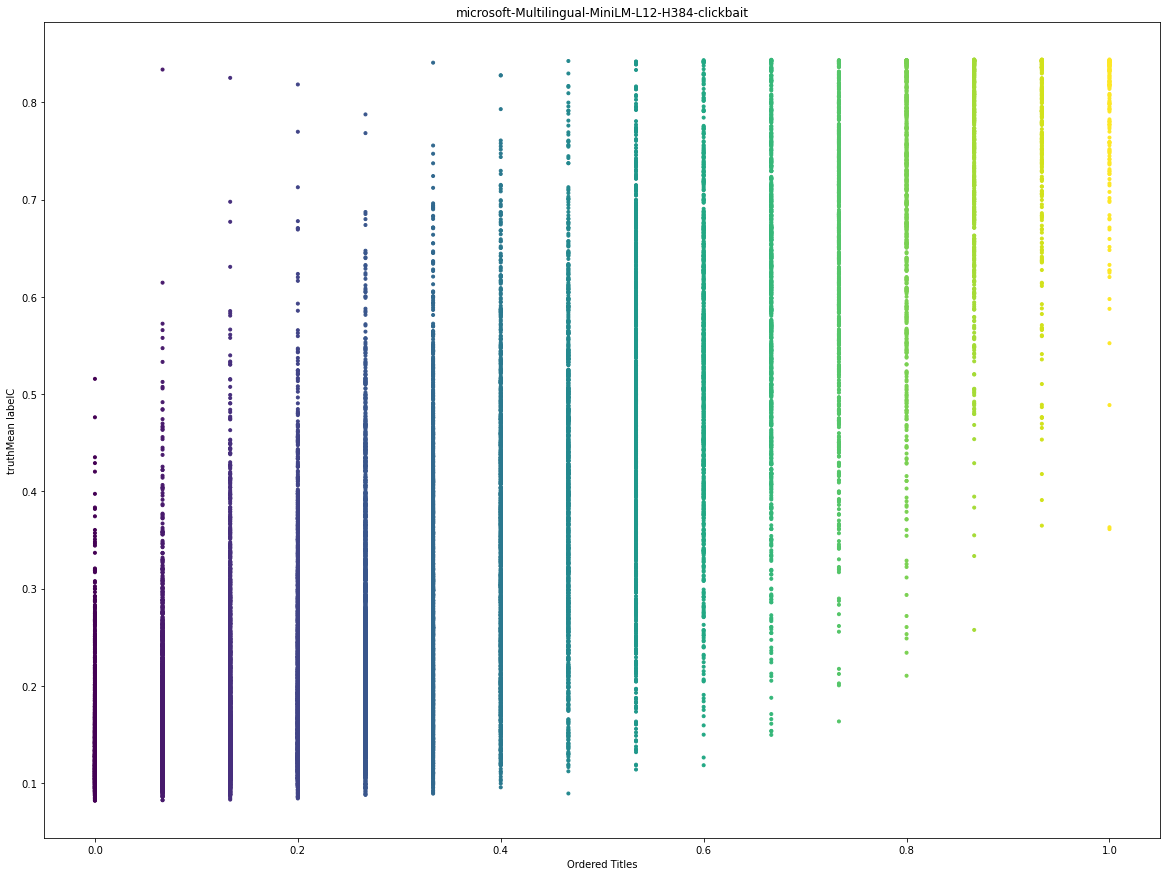

In [71]:
plt.figure(figsize=(20, 15))
plt.title(modelIn)
plt.xlabel("Ordered Titles")

plt.ylabel(actualOutput + " " + computedOutput)

x = np.array(range(0, tct1.shape[0]))
y = tct1[actualOutput]
# plt.scatter(x, y, c = color1, marker = "o", label = "Array elements")

x2 = np.array(range(0, tct2.shape[0]))
y2 = tct2[computedOutput]
# plt.scatter(x2, y2, c = color1, marker = "o", label = "Array elements")

x3 = tct1[actualOutput]
y3 = tct1[computedOutput]
plt.scatter(x3, y3, c = color2, marker = ".", label = "Array elements")

In [72]:
tct

,postText,targetTitle,targetDescription,truthMean,id,input_ids,attention_mask,labels,labelC
0,Newborn baby dies after mum fell asleep holdin...,Warning to parents after newborn baby girl die...,A baby girl less than one month old has died a...,0.400000,853643905732096000,"[0, 2356, 57332, 15546, 14792, 7103, 42555, 77...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.400000,0.349129
1,SpaceX Falcon 9 rocket boosts EchoStar communi...,SpaceX Falcon 9 rocket boosts EchoStar communi...,SpaceX Falcon 9 rocket boosts EchoStar communi...,0.000000,842322053713788929,"[0, 43045, 1542, 160378, 483, 13950, 126, 9755...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000,0.091407
2,"Twins dominate ""Superhero Day,"" dress as RBG a...","Twins Dominate 'Superhero Day,' Dress As RBG A...",Their mom wants them to shatter glass ceilings...,0.066667,837212414328328192,"[0, 92016, 7, 35462, 67, 44, 73903, 90865, 100...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.066667,0.132048
3,how moderate and reasonable,French Presidential Favourite Macron: Terroris...,"Macron describes terrorism as an ""imponderable...",0.666667,855411413430521856,"[0, 3642, 71644, 13, 136, 169022, 2]","[1, 1, 1, 1, 1, 1, 1]",0.666667,0.835336
4,US Congress: Republicans vote to limit ethics ...,US Congress: Republicans vote to limit ethics ...,Republicans in the House of Representatives vo...,0.066667,816208996310908932,"[0, 7082, 77699, 12, 131161, 7, 43374, 47, 174...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.066667,0.134572
...,...,...,...,...,...,...,...,...,...
17524,#ICYMI: Girl escaped car that entered Tweed Ri...,NSW floods: Girl escaped car that entered Twee...,Police divers will join the search this mornin...,0.066667,848991470484934656,"[0, 468, 16259, 1723, 10101, 12, 45327, 144281...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.066667,0.154370
17525,Inside the fight to reinvent financial advice ...,The XX Factor: Inside The Fight To Reinvent Fi...,"Women live longer, earn less and are less like...",0.400000,857640501650096132,"[0, 187040, 70, 78431, 47, 456, 132894, 53477,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.400000,0.513747
17526,Shetland Islands could go independent if Scotl...,Shetland Islands could go independent if Scotl...,The Shetland Islands could become an overseas ...,0.000000,851323109449891841,"[0, 4687, 74041, 18481, 7, 5809, 738, 41371, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.000000,0.182122
17527,A Japanese man was found dead on top of his si...,A Japanese Man Was Crushed to Death by His Six...,A man simply known as Joji was found buried un...,0.200000,838502128960344064,"[0, 62, 148926, 332, 509, 14037, 103494, 98, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000,0.289679


In [73]:
tct[[computedOutput, actualOutput]].describe()

,labelC,truthMean
count,17529.000000,17529.000000
mean,0.326725,0.328435
std,0.208462,0.250935
min,0.081832,0.000000
25%,0.154956,0.133333
50%,0.251615,0.266667
75%,0.459908,0.466667
max,0.844052,1.000000


In [74]:
tct.corr()

,truthMean,labels,labelC
truthMean,1.000000,1.000000,0.829176
labels,1.000000,1.000000,0.829176
labelC,0.829176,0.829176,1.000000


In [50]:
from transformers import pipeline

In [51]:
model.to(torch.device("cpu"))

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elemen

In [52]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [53]:
classifier

In [54]:
classifier("Nous sommes très heureux de vous présenter la bibliothèque 🤗 Transformers.")

[{'label': 'LABEL_0', 'score': 0.6049768328666687}]

In [55]:
classifier(["The key to truly great chicken soup", "La clef d'une bonne soupe au poulet"])

Disabling tokenizer parallelism, we're using DataLoader multithreading already


[{'label': 'LABEL_0', 'score': 0.6421559453010559},
 {'label': 'LABEL_0', 'score': 0.6194285750389099}]

In [56]:
classifier("Traité de mathématiques amusantes.")

[{'label': 'LABEL_0', 'score': 0.6694268584251404}]

In [57]:
tct.loc[tct.labelC != tct.labels]

,postText,targetTitle,targetDescription,truthMean,id,input_ids,attention_mask,labels,labelC
0,"""...putting America first so that we can sweep...",Sarah Palin: President Trump Should ‘Call for ...,Sarah Palin talked about a return to national ...,0.400000,814618281734733824,"[0, 44, 27, 7077, 1916, 21629, 5117, 221, 450,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.400000,0.455288
1,These 8 men are richer than 3.6 billion people...,These 8 men are richer than 3.6 billion people...,Eight men now control as much wealth as the wo...,0.733333,821073792793452544,"[0, 32255, 382, 453, 621, 118513, 42, 3501, 6,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.733333,0.748555
2,Alec Baldwin says that angry 2007 voicemail hu...,Alec Baldwin Says That Angry 2007 Voicemail Hu...,He's spent the past 10 years making amends.,0.200000,849029556757549056,"[0, 62, 8996, 77462, 9494, 17378, 450, 348, 12...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000,0.264273
3,Kasich signs 20-week abortion ban in Ohio but ...,Kasich Signs 20-Week Ohio Abortion Ban but Vet...,The 'heartbeat bill' would have prohibited mos...,0.333333,808789369754677249,"[0, 98135, 206, 24092, 7, 13484, 47477, 64853,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.333333,0.145429
4,Sherlock takes a turn for the morbid in 'The L...,Sherlock season 4 episode 2 review: Benedict C...,"Well, that was fun. Rarely can drama have come...",0.600000,818400683846144000,"[0, 204860, 51776, 10, 15504, 100, 70, 87131, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.600000,0.348557
...,...,...,...,...,...,...,...,...,...
4378,How West Papua's gold rush has created a waste...,How West Papua's gold rush has created a waste...,The western half of the Indonesian-controlled ...,0.333333,828918828830695424,"[0, 11249, 10542, 117162, 25, 7, 86761, 6, 865...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.333333,0.460068
4379,Peter Capaldi says new Doctor Who series will ...,Peter Capaldi says new Doctor Who series will ...,Actor says he has filmed his death in series w...,0.000000,852944455871197184,"[0, 7948, 14304, 24313, 17378, 3525, 52625, 40...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.000000,0.138506
4380,"Steph Curry and LeBron James top jersey sales,...","Stephen Curry, LeBron James Lead List of NBA's...",Golden State Warriors star Stephen Curry may...,0.200000,823995304848539648,"[0, 50478, 127, 17065, 1294, 136, 636, 571, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000,0.224606
4381,Thai mother of baby murdered on Facebook Live ...,'I saw him drop my daughter with the rope and ...,"Jiranuch Trairat, from Phuket, was left devast...",0.533333,857572808662142976,"[0, 13322, 42732, 111, 15546, 162882, 297, 98,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.533333,0.538352


In [58]:
classifier("99% des gens n'arrivent pas à voir le chien sur cette image", return_all_scores=True)

[[{'label': 'LABEL_0', 'score': 0.6564618349075317}]]